# Shortest Path

## Imports


In [1]:
import sys
sys.path.append("../../")
import time

import torch

from dlpmln import DeepLPMLN
from network import FC
from dataGen import obsList, obsListTest, dataList, dataListTest

from IPython.display import display
from PIL import Image

(322, 24)


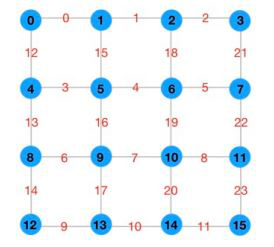

In [2]:
path="4by4_grid.jpg"
display(Image.open(path))

Consider a 4*4 grid above.

There are 16 nodes and 24 edges in the grid. Given any 2 nodes in the grid, the target is to find
a shortest path between them. We use the dataset from (Xu et al. 2018), which was used to
demonstrate the effectiveness of semantic constraints for enhanced neural network learning.
Each example is a 4 by 4 grid G = (V,E), where |V | = 16,|E| = 24. The source and the destination
nodes are randomly picked up, as well as 8 edges are randomly removed to increase the
difficulty. The dataset is divided into 60/20/20 train/validation/test examples.

We apply DeepLPMLN on this problem using the same dataset and the neural network model
from (Xu et al. 2018), but with a different training target: to maximize the probability of the
training data under the semantics of DeepLPMLN.

## Neural Network Rule

In [3]:
nnRule = '''
grid(g).
nn(m(g, 24), nn_edge, [t, f]) :- grid(g). 
'''

## ASP Rule

In [4]:
aspRule = '''
nn_edge(X) :- nn_edge(g,X,t).

sp(0,1) :- nn_edge(0).
sp(1,2) :- nn_edge(1).
sp(2,3) :- nn_edge(2).
sp(4,5) :- nn_edge(3).
sp(5,6) :- nn_edge(4).
sp(6,7) :- nn_edge(5).
sp(8,9) :- nn_edge(6).
sp(9,10) :- nn_edge(7).
sp(10,11) :- nn_edge(8).
sp(12,13) :- nn_edge(9).
sp(13,14) :- nn_edge(10).
sp(14,15) :- nn_edge(11).
sp(0,4) :- nn_edge(12).
sp(4,8) :- nn_edge(13).
sp(8,12) :- nn_edge(14).
sp(1,5) :- nn_edge(15).
sp(5,9) :- nn_edge(16).
sp(9,13) :- nn_edge(17).
sp(2,6) :- nn_edge(18).
sp(6,10) :- nn_edge(19).
sp(10,14) :- nn_edge(20).
sp(3,7) :- nn_edge(21).
sp(7,11) :- nn_edge(22).
sp(11,15) :- nn_edge(23).

sp(X,Y) :- sp(Y,X).
'''


## Constraints

In [5]:
remove_con = '''
% [nr] 1. No removed edges should be predicted
mistake :- nn_edge(X), removed(X).
'''

path_con = '''
% [p] 2. Prediction must form simple path(s)
% that is: the degree of nodes should be either 0 or 2
mistake :- X=0..15, #count{Y: sp(X,Y)} = 1.
mistake :- X=0..15, #count{Y: sp(X,Y)} >= 3.
'''

reach_con = '''
% [r] 3. Every 2 nodes in the prediction must be reachable
reachable(X, Y) :- sp(X, Y).
reachable(X, Y) :- reachable(X, Z), sp(Z, Y).
mistake :- sp(X, _), sp(Y, _), not reachable(X, Y).
'''

opt_con = '''
% [o] 4. Predicted path should contain least edges
:~ nn_edge(X). [1, X]
'''


## Data Format


### dataset

A dictionary with 6 keys: train, test, valid, train_label, test_label, valid_label  
dataset[‘train’] is a numpy array of size (966, 40). It consists of 966 data as follows.  
[  
data,  
...,  
data  
]  
where data is a vector (numpy array) of length 40. For example, the data shown below  
[  
11101 10111 10001 11110 1010  
01000 00000 00010 0  
]  
means the edges 3, 6, 11, 12, 13, 19, 21, 23 are removed; and the nodes 1 and 13 are  
the starting and ending nodes.  
dataset[‘train_label’] is a numpy array of size (996, 24). It consists of 966 label as  
follows.  
[  
label,  
...,  
label  
]  
where label is a vector (numpy array) of length 24. For example, the label shown below  
[  
00000 00000 00000 11100 0000  
]  
means that the edges 15, 16, 17 form a shortest path.  
dataset[‘test’] is a numpy array of size (322, 40).  
dataset[‘valid’] is a numpy array of size (322, 40).  
dataset[‘test_label’] is a numpy array of size (322, 24).  
dataset[‘valid_label’] is a numpy array of size (322, 24).  


## Construct nnMapping and set optimizers

In [6]:
m = FC(40, 50, 50, 50, 50, 50, 24)
nnMapping = {"m":m}
optimizers = {'m':torch.optim.Adam(m.parameters(), lr=0.001)}

Neural Network (MLP) Structure: (40, 50, 50, 50, 50, 50, 24)


## Create DeepLPMLN Object

In [7]:
dlpmlnObj = DeepLPMLN(nnRule+aspRule+path_con+reach_con+opt_con, nnMapping, optimizers)

## Create mvppList

In [8]:
mvppList = [remove_con, path_con, reach_con, remove_con+path_con, remove_con+reach_con, path_con+reach_con, remove_con+path_con+reach_con, remove_con+path_con+reach_con+opt_con]
mvppList = [aspRule+i for i in mvppList]

In [9]:
print('-------------------')
for idx, constraint in enumerate(mvppList):
    print('Constraint {} is\n{}\n-------------------'.format(idx+1, constraint))

-------------------
Constraint 1 is

nn_edge(X) :- nn_edge(g,X,t).

sp(0,1) :- nn_edge(0).
sp(1,2) :- nn_edge(1).
sp(2,3) :- nn_edge(2).
sp(4,5) :- nn_edge(3).
sp(5,6) :- nn_edge(4).
sp(6,7) :- nn_edge(5).
sp(8,9) :- nn_edge(6).
sp(9,10) :- nn_edge(7).
sp(10,11) :- nn_edge(8).
sp(12,13) :- nn_edge(9).
sp(13,14) :- nn_edge(10).
sp(14,15) :- nn_edge(11).
sp(0,4) :- nn_edge(12).
sp(4,8) :- nn_edge(13).
sp(8,12) :- nn_edge(14).
sp(1,5) :- nn_edge(15).
sp(5,9) :- nn_edge(16).
sp(9,13) :- nn_edge(17).
sp(2,6) :- nn_edge(18).
sp(6,10) :- nn_edge(19).
sp(10,14) :- nn_edge(20).
sp(3,7) :- nn_edge(21).
sp(7,11) :- nn_edge(22).
sp(11,15) :- nn_edge(23).

sp(X,Y) :- sp(Y,X).

% [nr] 1. No removed edges should be predicted
mistake :- nn_edge(X), removed(X).

-------------------
Constraint 2 is

nn_edge(X) :- nn_edge(g,X,t).

sp(0,1) :- nn_edge(0).
sp(1,2) :- nn_edge(1).
sp(2,3) :- nn_edge(2).
sp(4,5) :- nn_edge(3).
sp(5,6) :- nn_edge(4).
sp(6,7) :- nn_edge(5).
sp(8,9) :- nn_edge(6).
sp(9,10) :- nn_

In [10]:
startTime = time.time()
for i in range(500):
    print('Epoch {}...'.format(i+1))
    time1 = time.time()
    dlpmlnObj.learn(dataList=dataList, obsList=obsList, epoch=1, opt=True, storeSM=True)
    time2 = time.time()
    dlpmlnObj.testConstraint(dataList=dataListTest, obsList=obsListTest, mvppList=mvppList)
    print("--- train time: %s seconds ---" % (time2 - time1))
    print("--- test time: %s seconds ---" % (time.time() - time2))
    print('--- total time from beginning: %s minutes ---' % int((time.time() - startTime)/60) )


Epoch 1...
Training for epoch 1 ...
The accuracy for constraint 1 is 1.0
The accuracy for constraint 2 is 0.0
The accuracy for constraint 3 is 1.0
The accuracy for constraint 4 is 0.0
The accuracy for constraint 5 is 1.0
The accuracy for constraint 6 is 0.0
The accuracy for constraint 7 is 0.0
The accuracy for constraint 8 is 0.0
--- train time: 17.74476647377014 seconds ---
--- test time: 5.249319553375244 seconds ---
--- total time from beginning: 0 minutes ---
Epoch 2...
Training for epoch 1 ...
The accuracy for constraint 1 is 1.0
The accuracy for constraint 2 is 0.0
The accuracy for constraint 3 is 1.0
The accuracy for constraint 4 is 0.0
The accuracy for constraint 5 is 1.0
The accuracy for constraint 6 is 0.0
The accuracy for constraint 7 is 0.0
The accuracy for constraint 8 is 0.0
--- train time: 10.556365251541138 seconds ---
--- test time: 5.697921514511108 seconds ---
--- total time from beginning: 0 minutes ---
Epoch 3...
Training for epoch 1 ...
The accuracy for constraint

--- total time from beginning: 10 minutes ---
Epoch 29...
Training for epoch 1 ...
The accuracy for constraint 1 is 0.42857142857142855
The accuracy for constraint 2 is 0.9658385093167702
The accuracy for constraint 3 is 0.9875776397515528
The accuracy for constraint 4 is 0.4192546583850932
The accuracy for constraint 5 is 0.42857142857142855
The accuracy for constraint 6 is 0.9658385093167702
The accuracy for constraint 7 is 0.4192546583850932
The accuracy for constraint 8 is 0.4192546583850932
--- train time: 16.91002345085144 seconds ---
--- test time: 6.3024046421051025 seconds ---
--- total time from beginning: 10 minutes ---
Epoch 30...
Training for epoch 1 ...
The accuracy for constraint 1 is 0.422360248447205
The accuracy for constraint 2 is 0.9254658385093167
The accuracy for constraint 3 is 0.9937888198757764
The accuracy for constraint 4 is 0.391304347826087
The accuracy for constraint 5 is 0.422360248447205
The accuracy for constraint 6 is 0.9254658385093167
The accuracy fo

--- train time: 13.139545679092407 seconds ---
--- test time: 5.623089075088501 seconds ---
--- total time from beginning: 20 minutes ---
Epoch 58...
Training for epoch 1 ...
The accuracy for constraint 1 is 0.42857142857142855
The accuracy for constraint 2 is 0.9968944099378882
The accuracy for constraint 3 is 1.0
The accuracy for constraint 4 is 0.42857142857142855
The accuracy for constraint 5 is 0.42857142857142855
The accuracy for constraint 6 is 0.9968944099378882
The accuracy for constraint 7 is 0.42857142857142855
The accuracy for constraint 8 is 0.42857142857142855
--- train time: 12.861847639083862 seconds ---
--- test time: 5.52556586265564 seconds ---
--- total time from beginning: 20 minutes ---
Epoch 59...
Training for epoch 1 ...
The accuracy for constraint 1 is 0.422360248447205
The accuracy for constraint 2 is 0.9254658385093167
The accuracy for constraint 3 is 0.9906832298136646
The accuracy for constraint 4 is 0.40062111801242234
The accuracy for constraint 5 is 0.41

The accuracy for constraint 1 is 0.42857142857142855
The accuracy for constraint 2 is 1.0
The accuracy for constraint 3 is 1.0
The accuracy for constraint 4 is 0.42857142857142855
The accuracy for constraint 5 is 0.42857142857142855
The accuracy for constraint 6 is 1.0
The accuracy for constraint 7 is 0.42857142857142855
The accuracy for constraint 8 is 0.42857142857142855
--- train time: 13.465544939041138 seconds ---
--- test time: 5.8490941524505615 seconds ---
--- total time from beginning: 29 minutes ---
Epoch 88...
Training for epoch 1 ...
The accuracy for constraint 1 is 0.42857142857142855
The accuracy for constraint 2 is 1.0
The accuracy for constraint 3 is 1.0
The accuracy for constraint 4 is 0.42857142857142855
The accuracy for constraint 5 is 0.42857142857142855
The accuracy for constraint 6 is 1.0
The accuracy for constraint 7 is 0.42857142857142855
The accuracy for constraint 8 is 0.42857142857142855
--- train time: 13.354705572128296 seconds ---
--- test time: 5.75229239

The accuracy for constraint 7 is 0.42857142857142855
The accuracy for constraint 8 is 0.42857142857142855
--- train time: 13.757724285125732 seconds ---
--- test time: 5.687864065170288 seconds ---
--- total time from beginning: 39 minutes ---
Epoch 117...
Training for epoch 1 ...
The accuracy for constraint 1 is 0.42857142857142855
The accuracy for constraint 2 is 1.0
The accuracy for constraint 3 is 1.0
The accuracy for constraint 4 is 0.42857142857142855
The accuracy for constraint 5 is 0.42857142857142855
The accuracy for constraint 6 is 1.0
The accuracy for constraint 7 is 0.42857142857142855
The accuracy for constraint 8 is 0.42857142857142855
--- train time: 13.48058557510376 seconds ---
--- test time: 5.645039319992065 seconds ---
--- total time from beginning: 39 minutes ---
Epoch 118...
Training for epoch 1 ...
The accuracy for constraint 1 is 0.43788819875776397
The accuracy for constraint 2 is 0.9472049689440993
The accuracy for constraint 3 is 0.9937888198757764
The accura

Training for epoch 1 ...
The accuracy for constraint 1 is 0.42857142857142855
The accuracy for constraint 2 is 1.0
The accuracy for constraint 3 is 1.0
The accuracy for constraint 4 is 0.42857142857142855
The accuracy for constraint 5 is 0.42857142857142855
The accuracy for constraint 6 is 1.0
The accuracy for constraint 7 is 0.42857142857142855
The accuracy for constraint 8 is 0.42857142857142855
--- train time: 11.696929931640625 seconds ---
--- test time: 5.510478734970093 seconds ---
--- total time from beginning: 47 minutes ---
Epoch 146...
Training for epoch 1 ...
The accuracy for constraint 1 is 0.42857142857142855
The accuracy for constraint 2 is 1.0
The accuracy for constraint 3 is 1.0
The accuracy for constraint 4 is 0.42857142857142855
The accuracy for constraint 5 is 0.42857142857142855
The accuracy for constraint 6 is 1.0
The accuracy for constraint 7 is 0.42857142857142855
The accuracy for constraint 8 is 0.42857142857142855
--- train time: 11.582001686096191 seconds ---


The accuracy for constraint 8 is 0.42857142857142855
--- train time: 11.647959470748901 seconds ---
--- test time: 5.409890174865723 seconds ---
--- total time from beginning: 56 minutes ---
Epoch 174...
Training for epoch 1 ...
The accuracy for constraint 1 is 0.42857142857142855
The accuracy for constraint 2 is 1.0
The accuracy for constraint 3 is 1.0
The accuracy for constraint 4 is 0.42857142857142855
The accuracy for constraint 5 is 0.42857142857142855
The accuracy for constraint 6 is 1.0
The accuracy for constraint 7 is 0.42857142857142855
The accuracy for constraint 8 is 0.42857142857142855
--- train time: 11.627146244049072 seconds ---
--- test time: 5.537045240402222 seconds ---
--- total time from beginning: 56 minutes ---
Epoch 175...
Training for epoch 1 ...
The accuracy for constraint 1 is 0.42857142857142855
The accuracy for constraint 2 is 1.0
The accuracy for constraint 3 is 1.0
The accuracy for constraint 4 is 0.42857142857142855
The accuracy for constraint 5 is 0.4285

The accuracy for constraint 1 is 0.42857142857142855
The accuracy for constraint 2 is 1.0
The accuracy for constraint 3 is 1.0
The accuracy for constraint 4 is 0.42857142857142855
The accuracy for constraint 5 is 0.42857142857142855
The accuracy for constraint 6 is 1.0
The accuracy for constraint 7 is 0.42857142857142855
The accuracy for constraint 8 is 0.42857142857142855
--- train time: 12.127436637878418 seconds ---
--- test time: 5.3767616748809814 seconds ---
--- total time from beginning: 64 minutes ---
Epoch 204...
Training for epoch 1 ...
The accuracy for constraint 1 is 0.42857142857142855
The accuracy for constraint 2 is 1.0
The accuracy for constraint 3 is 1.0
The accuracy for constraint 4 is 0.42857142857142855
The accuracy for constraint 5 is 0.42857142857142855
The accuracy for constraint 6 is 1.0
The accuracy for constraint 7 is 0.42857142857142855
The accuracy for constraint 8 is 0.42857142857142855
--- train time: 12.39662480354309 seconds ---
--- test time: 5.38744902

The accuracy for constraint 5 is 0.42857142857142855
The accuracy for constraint 6 is 1.0
The accuracy for constraint 7 is 0.42857142857142855
The accuracy for constraint 8 is 0.42857142857142855
--- train time: 12.150725603103638 seconds ---
--- test time: 5.479904890060425 seconds ---
--- total time from beginning: 72 minutes ---
Epoch 232...
Training for epoch 1 ...
The accuracy for constraint 1 is 0.42857142857142855
The accuracy for constraint 2 is 1.0
The accuracy for constraint 3 is 1.0
The accuracy for constraint 4 is 0.42857142857142855
The accuracy for constraint 5 is 0.42857142857142855
The accuracy for constraint 6 is 1.0
The accuracy for constraint 7 is 0.42857142857142855
The accuracy for constraint 8 is 0.42857142857142855
--- train time: 12.274518251419067 seconds ---
--- test time: 5.424781560897827 seconds ---
--- total time from beginning: 73 minutes ---
Epoch 233...
Training for epoch 1 ...
The accuracy for constraint 1 is 0.42857142857142855
The accuracy for constr

--- test time: 5.097626686096191 seconds ---
--- total time from beginning: 79 minutes ---
Epoch 261...
Training for epoch 1 ...
The accuracy for constraint 1 is 0.42857142857142855
The accuracy for constraint 2 is 1.0
The accuracy for constraint 3 is 1.0
The accuracy for constraint 4 is 0.42857142857142855
The accuracy for constraint 5 is 0.42857142857142855
The accuracy for constraint 6 is 1.0
The accuracy for constraint 7 is 0.42857142857142855
The accuracy for constraint 8 is 0.42857142857142855
--- train time: 7.345372200012207 seconds ---
--- test time: 5.116190433502197 seconds ---
--- total time from beginning: 80 minutes ---
Epoch 262...
Training for epoch 1 ...
The accuracy for constraint 1 is 0.42857142857142855
The accuracy for constraint 2 is 1.0
The accuracy for constraint 3 is 1.0
The accuracy for constraint 4 is 0.42857142857142855
The accuracy for constraint 5 is 0.42857142857142855
The accuracy for constraint 6 is 1.0
The accuracy for constraint 7 is 0.428571428571428

The accuracy for constraint 5 is 0.4254658385093168
The accuracy for constraint 6 is 1.0
The accuracy for constraint 7 is 0.4254658385093168
The accuracy for constraint 8 is 0.4254658385093168
--- train time: 7.424456357955933 seconds ---
--- test time: 4.98245096206665 seconds ---
--- total time from beginning: 86 minutes ---
Epoch 291...
Training for epoch 1 ...
The accuracy for constraint 1 is 0.4254658385093168
The accuracy for constraint 2 is 1.0
The accuracy for constraint 3 is 1.0
The accuracy for constraint 4 is 0.4254658385093168
The accuracy for constraint 5 is 0.4254658385093168
The accuracy for constraint 6 is 1.0
The accuracy for constraint 7 is 0.4254658385093168
The accuracy for constraint 8 is 0.4254658385093168
--- train time: 7.2087318897247314 seconds ---
--- test time: 5.040062665939331 seconds ---
--- total time from beginning: 86 minutes ---
Epoch 292...
Training for epoch 1 ...
The accuracy for constraint 1 is 0.4254658385093168
The accuracy for constraint 2 is 1

The accuracy for constraint 7 is 0.4254658385093168
The accuracy for constraint 8 is 0.4254658385093168
--- train time: 7.317069053649902 seconds ---
--- test time: 5.1688923835754395 seconds ---
--- total time from beginning: 92 minutes ---
Epoch 320...
Training for epoch 1 ...
The accuracy for constraint 1 is 0.4254658385093168
The accuracy for constraint 2 is 1.0
The accuracy for constraint 3 is 1.0
The accuracy for constraint 4 is 0.4254658385093168
The accuracy for constraint 5 is 0.4254658385093168
The accuracy for constraint 6 is 1.0
The accuracy for constraint 7 is 0.4254658385093168
The accuracy for constraint 8 is 0.4254658385093168
--- train time: 7.235107183456421 seconds ---
--- test time: 5.08396053314209 seconds ---
--- total time from beginning: 92 minutes ---
Epoch 321...
Training for epoch 1 ...
The accuracy for constraint 1 is 0.4254658385093168
The accuracy for constraint 2 is 1.0
The accuracy for constraint 3 is 1.0
The accuracy for constraint 4 is 0.42546583850931

The accuracy for constraint 5 is 0.4254658385093168
The accuracy for constraint 6 is 1.0
The accuracy for constraint 7 is 0.4254658385093168
The accuracy for constraint 8 is 0.4254658385093168
--- train time: 7.059404134750366 seconds ---
--- test time: 5.082030773162842 seconds ---
--- total time from beginning: 98 minutes ---
Epoch 350...
Training for epoch 1 ...
The accuracy for constraint 1 is 0.4254658385093168
The accuracy for constraint 2 is 1.0
The accuracy for constraint 3 is 1.0
The accuracy for constraint 4 is 0.4254658385093168
The accuracy for constraint 5 is 0.4254658385093168
The accuracy for constraint 6 is 1.0
The accuracy for constraint 7 is 0.4254658385093168
The accuracy for constraint 8 is 0.4254658385093168
--- train time: 7.076972723007202 seconds ---
--- test time: 5.08300518989563 seconds ---
--- total time from beginning: 98 minutes ---
Epoch 351...
Training for epoch 1 ...
The accuracy for constraint 1 is 0.4254658385093168
The accuracy for constraint 2 is 1.

--- test time: 5.073226690292358 seconds ---
--- total time from beginning: 104 minutes ---
Epoch 379...
Training for epoch 1 ...
The accuracy for constraint 1 is 0.422360248447205
The accuracy for constraint 2 is 1.0
The accuracy for constraint 3 is 1.0
The accuracy for constraint 4 is 0.422360248447205
The accuracy for constraint 5 is 0.422360248447205
The accuracy for constraint 6 is 1.0
The accuracy for constraint 7 is 0.422360248447205
The accuracy for constraint 8 is 0.422360248447205
--- train time: 7.163862466812134 seconds ---
--- test time: 5.100547552108765 seconds ---
--- total time from beginning: 104 minutes ---
Epoch 380...
Training for epoch 1 ...
The accuracy for constraint 1 is 0.422360248447205
The accuracy for constraint 2 is 1.0
The accuracy for constraint 3 is 1.0
The accuracy for constraint 4 is 0.422360248447205
The accuracy for constraint 5 is 0.422360248447205
The accuracy for constraint 6 is 1.0
The accuracy for constraint 7 is 0.422360248447205
The accuracy 

The accuracy for constraint 1 is 0.4254658385093168
The accuracy for constraint 2 is 1.0
The accuracy for constraint 3 is 1.0
The accuracy for constraint 4 is 0.4254658385093168
The accuracy for constraint 5 is 0.4254658385093168
The accuracy for constraint 6 is 1.0
The accuracy for constraint 7 is 0.4254658385093168
The accuracy for constraint 8 is 0.4254658385093168
--- train time: 7.267314910888672 seconds ---
--- test time: 5.082983732223511 seconds ---
--- total time from beginning: 110 minutes ---
Epoch 409...
Training for epoch 1 ...
The accuracy for constraint 1 is 0.43167701863354035
The accuracy for constraint 2 is 0.9937888198757764
The accuracy for constraint 3 is 1.0
The accuracy for constraint 4 is 0.4254658385093168
The accuracy for constraint 5 is 0.43167701863354035
The accuracy for constraint 6 is 0.9937888198757764
The accuracy for constraint 7 is 0.4254658385093168
The accuracy for constraint 8 is 0.4254658385093168
--- train time: 7.316092491149902 seconds ---
--- 

--- test time: 5.025422096252441 seconds ---
--- total time from beginning: 116 minutes ---
Epoch 438...
Training for epoch 1 ...
The accuracy for constraint 1 is 0.4254658385093168
The accuracy for constraint 2 is 1.0
The accuracy for constraint 3 is 1.0
The accuracy for constraint 4 is 0.4254658385093168
The accuracy for constraint 5 is 0.4254658385093168
The accuracy for constraint 6 is 1.0
The accuracy for constraint 7 is 0.4254658385093168
The accuracy for constraint 8 is 0.4254658385093168
--- train time: 7.180456161499023 seconds ---
--- test time: 5.141538858413696 seconds ---
--- total time from beginning: 116 minutes ---
Epoch 439...
Training for epoch 1 ...
The accuracy for constraint 1 is 0.4658385093167702
The accuracy for constraint 2 is 0.6149068322981367
The accuracy for constraint 3 is 0.9720496894409938
The accuracy for constraint 4 is 0.2857142857142857
The accuracy for constraint 5 is 0.45652173913043476
The accuracy for constraint 6 is 0.6149068322981367
The accura

The accuracy for constraint 7 is 0.4254658385093168
The accuracy for constraint 8 is 0.4254658385093168
--- train time: 5.718371868133545 seconds ---
--- test time: 4.837035179138184 seconds ---
--- total time from beginning: 121 minutes ---
Epoch 468...
Training for epoch 1 ...
The accuracy for constraint 1 is 0.4254658385093168
The accuracy for constraint 2 is 1.0
The accuracy for constraint 3 is 1.0
The accuracy for constraint 4 is 0.4254658385093168
The accuracy for constraint 5 is 0.4254658385093168
The accuracy for constraint 6 is 1.0
The accuracy for constraint 7 is 0.4254658385093168
The accuracy for constraint 8 is 0.4254658385093168
--- train time: 5.774036407470703 seconds ---
--- test time: 4.857527017593384 seconds ---
--- total time from beginning: 122 minutes ---
Epoch 469...
Training for epoch 1 ...
The accuracy for constraint 1 is 0.4254658385093168
The accuracy for constraint 2 is 1.0
The accuracy for constraint 3 is 1.0
The accuracy for constraint 4 is 0.425465838509

--- train time: 5.62175726890564 seconds ---
--- test time: 4.821438312530518 seconds ---
--- total time from beginning: 126 minutes ---
Epoch 497...
Training for epoch 1 ...
The accuracy for constraint 1 is 0.4254658385093168
The accuracy for constraint 2 is 1.0
The accuracy for constraint 3 is 1.0
The accuracy for constraint 4 is 0.4254658385093168
The accuracy for constraint 5 is 0.4254658385093168
The accuracy for constraint 6 is 1.0
The accuracy for constraint 7 is 0.4254658385093168
The accuracy for constraint 8 is 0.4254658385093168
--- train time: 5.592495918273926 seconds ---
--- test time: 4.785306692123413 seconds ---
--- total time from beginning: 127 minutes ---
Epoch 498...
Training for epoch 1 ...
The accuracy for constraint 1 is 0.4254658385093168
The accuracy for constraint 2 is 1.0
The accuracy for constraint 3 is 1.0
The accuracy for constraint 4 is 0.4254658385093168
The accuracy for constraint 5 is 0.4254658385093168
The accuracy for constraint 6 is 1.0
The accurac

More results: The following table shows the constraint accuracy of the same MLP trained with
different constraints (denoted in the parentheses) for 500 epochs.

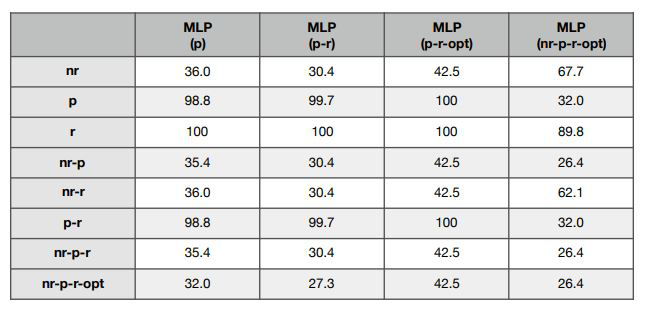

In [11]:
path="constraint_accuracies.jpg"
display(Image.open(path))